In [4]:
from aicsimageio import AICSImage
from tifffile import imsave
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from itkwidgets import view 
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
plt.rcParams["figure.figsize"] = [16, 12]

In [2]:
!pip install mrc big-fish

Looking in indexes: https://artifactory.corp.alleninstitute.org/artifactory/api/pypi/pypi-virtual/simple


In [5]:
import os
import numpy as np
import bigfish
import bigfish.stack as stack
import bigfish.detection as detection
import bigfish.multistack as multistack
import bigfish.plot as plot

In [6]:
print("Big-FISH version: {0}".format(bigfish.__version__))

Big-FISH version: 0.6.2


In [7]:
path_input = "TOP2A_003_005.tiff"

In [8]:
rna = stack.read_image(path_input)
#rna = stack.read_image(os.path.join(path_input, "experiment_1_smfish_fov_1.tif"))
print("rna stack")
print("\r shape: {0}".format(rna.shape))
print("\r dtype: {0}".format(rna.dtype), "\n")

rna stack
 shape: (51, 2048, 2048)
 dtype: uint16 



In [9]:
rna_slice = rna[30]
rna_slice.shape

(2048, 2048)

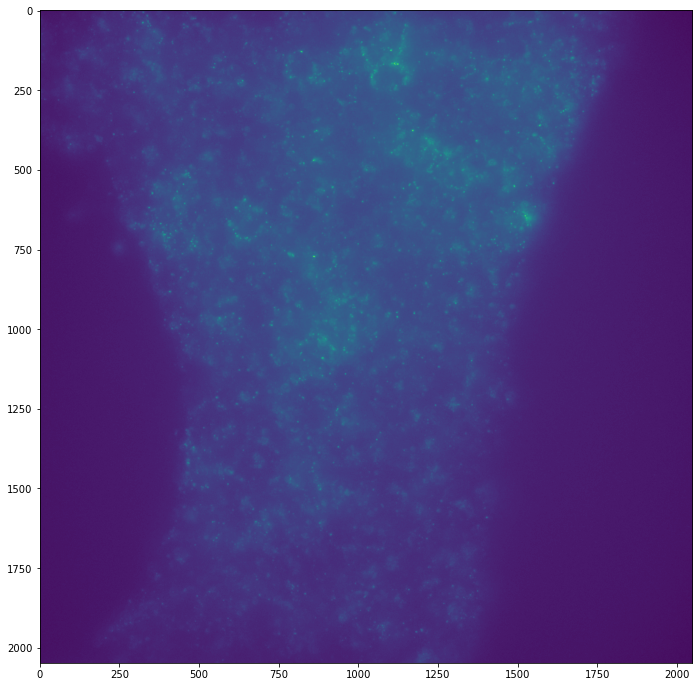

In [21]:
plt.imshow(rna_slice)

In [10]:
rna_2d = rna_slice
print("smfish channel (one z-slice)")
print("\r shape: {0}".format(rna_2d.shape))
print("\r dtype: {0}".format(rna_2d.dtype))

smfish channel (one z-slice)
 shape: (2048, 2048)
 dtype: uint16


In [11]:
rna_2d_rescaled = stack.rescale(rna_2d, channel_to_stretch=None)
rna_2d_stretched = stack.rescale(rna_2d, channel_to_stretch=0)

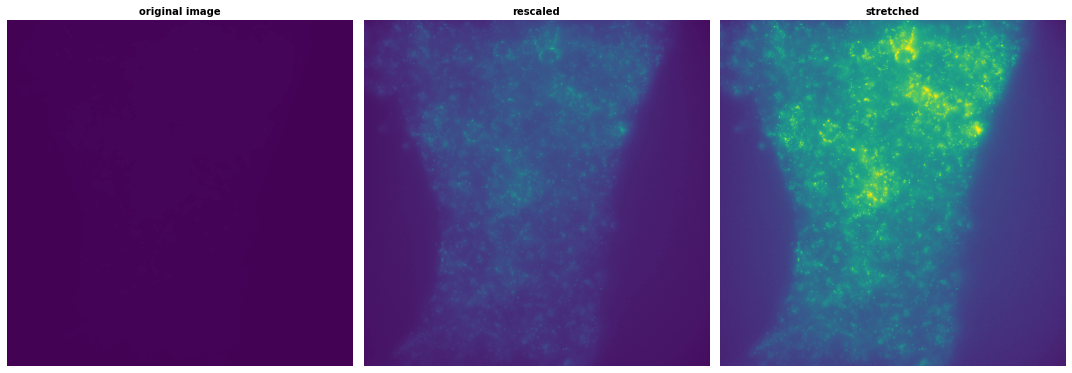

In [28]:
images = [rna_2d, rna_2d_rescaled, rna_2d_stretched]
titles = ["original image", "rescaled", "stretched"]
plot.plot_images(images, titles=titles)

In [12]:
rna_mip = stack.maximum_projection(rna)

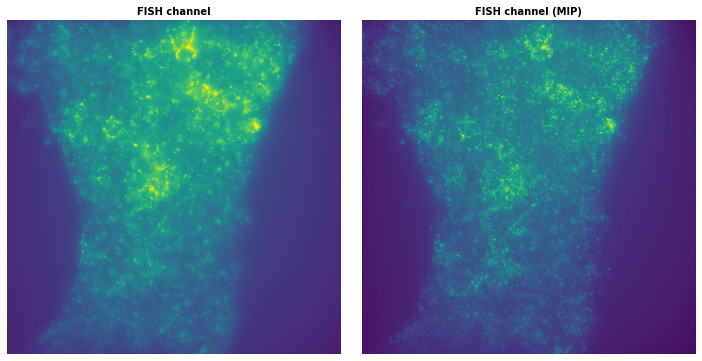

In [30]:
slice_num=30
images = [rna[slice_num,:,:], rna_mip]  #Plotting 11th slice from the rna image stack
titles = ["FISH channel", "FISH channel (MIP)"]
plot.plot_images(images, titles=titles, framesize=(10, 5), contrast=True)

In [31]:
rna_focus = stack.focus_projection(rna, proportion=0.75, neighborhood_size=7, method="median")

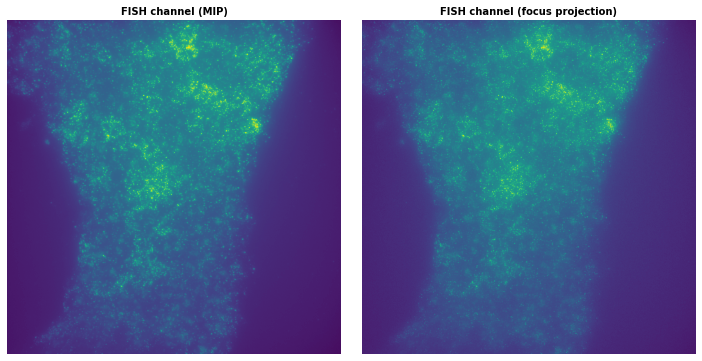

In [32]:
# RNA
images = [rna_mip, rna_focus]
titles = ["FISH channel (MIP)", "FISH channel (focus projection)"]
plot.plot_images(images, titles=titles, framesize=(10, 5), contrast=True)

In [33]:
rna_focus.shape

(2048, 2048)

In [34]:
rna.shape

(51, 2048, 2048)

In [35]:
# spot detection 
spots, threshold = detection.detect_spots(
    images=rna,
    return_threshold=True,
    voxel_size=(300, 103, 103),  # in nanometer (one value per dimension zyx)
    spot_radius=(350, 150, 150))  # in nanometer (one value per dimension zyx)
print("detected spots")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype))
print("\r threshold: {0}".format(threshold))

detected spots
 shape: (10086, 3)
 dtype: int64
 threshold: 78.0


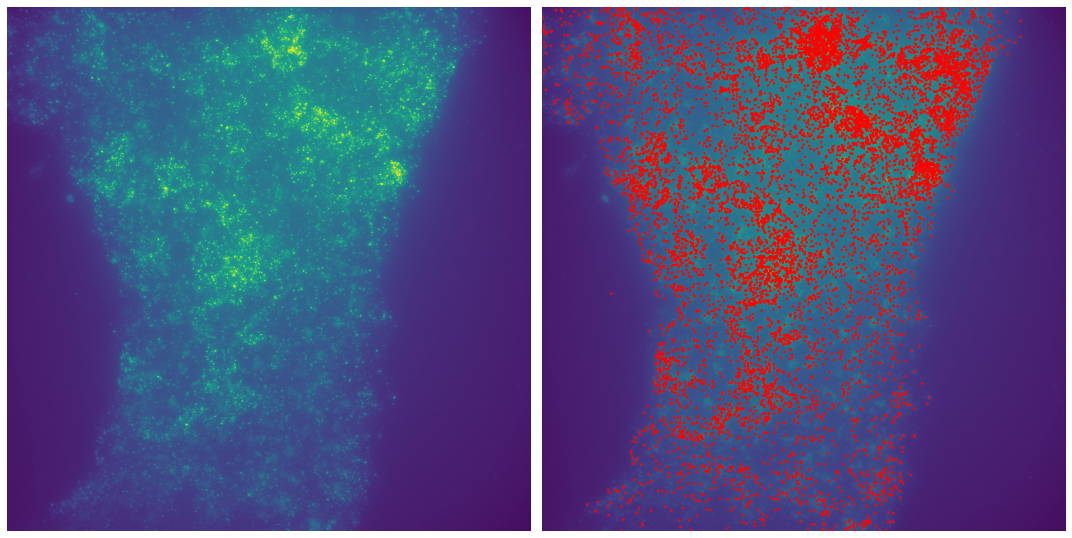

In [36]:
plot.plot_detection(rna_mip, spots, contrast=True)

In [37]:
# dense region decomposition
spots_post_decomposition, dense_regions, reference_spot = detection.decompose_dense(
    image=rna,
    spots=spots,
    voxel_size=(300, 103, 103),
    spot_radius=(350, 150, 150),
    alpha=0.7,  # alpha impacts the number of spots per candidate region
    beta=1,  # beta impacts the number of candidate regions to decompose
    gamma=5)  # gamma the filtering step to denoise the image
print("detected spots before decomposition")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype), "\n")
print("detected spots after decomposition")
print("\r shape: {0}".format(spots_post_decomposition.shape))
print("\r dtype: {0}".format(spots_post_decomposition.dtype))

detected spots before decomposition
 shape: (10086, 3)
 dtype: int64 

detected spots after decomposition
 shape: (11948, 3)
 dtype: int64


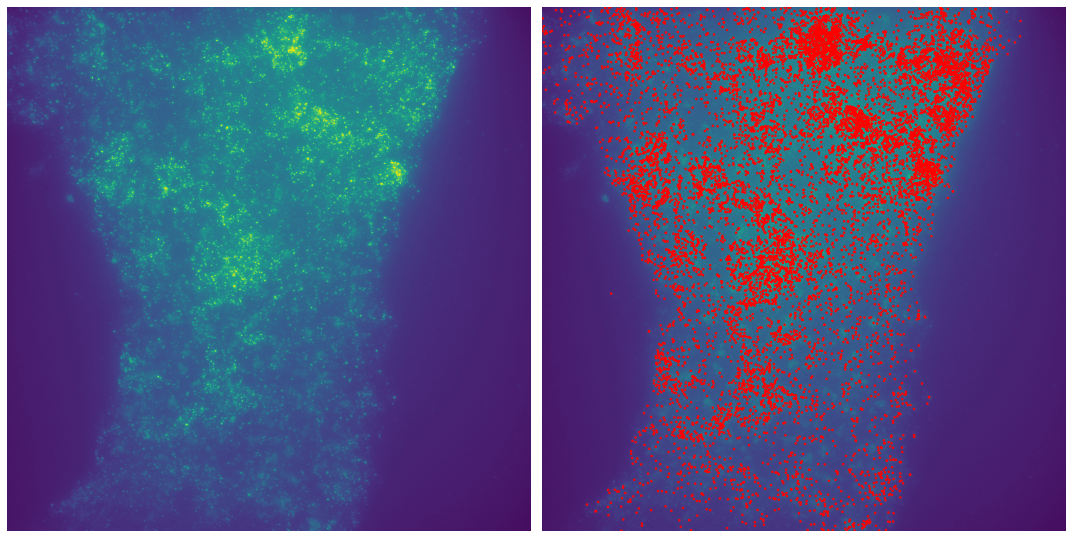

In [38]:
plot.plot_detection(rna_mip, spots_post_decomposition, contrast=True)

In [40]:
spots_post_decomposition

array([[   0, 1490,  774],
       [   0, 1879,  317],
       [   0, 1900,  326],
       ...,
       [  49, 1035,  830],
       [  49, 1110,  896],
       [  49, 1171,  745]])

In [43]:
rna_mip

array([[373, 374, 388, ..., 369, 335, 310],
       [377, 393, 408, ..., 391, 364, 375],
       [382, 424, 391, ..., 370, 358, 351],
       ...,
       [388, 375, 392, ..., 349, 351, 361],
       [380, 388, 417, ..., 357, 369, 361],
       [368, 375, 377, ..., 351, 345, 316]], dtype=uint16)

In [44]:
rna

array([[[305, 334, 321, ..., 294, 279, 299],
        [332, 310, 375, ..., 391, 320, 307],
        [290, 355, 321, ..., 330, 333, 299],
        ...,
        [294, 330, 294, ..., 324, 307, 265],
        [285, 335, 320, ..., 334, 290, 274],
        [336, 305, 322, ..., 258, 276, 255]],

       [[298, 294, 325, ..., 349, 335, 266],
        [303, 390, 379, ..., 346, 323, 323],
        [348, 367, 306, ..., 294, 335, 327],
        ...,
        [349, 291, 285, ..., 311, 314, 292],
        [322, 372, 284, ..., 289, 309, 318],
        [298, 297, 258, ..., 317, 301, 245]],

       [[373, 332, 365, ..., 294, 304, 269],
        [320, 367, 361, ..., 368, 359, 277],
        [362, 335, 353, ..., 296, 306, 331],
        ...,
        [321, 270, 294, ..., 349, 325, 298],
        [310, 315, 386, ..., 303, 329, 303],
        [287, 308, 312, ..., 270, 259, 292]],

       ...,

       [[301, 328, 313, ..., 282, 265, 245],
        [359, 334, 302, ..., 317, 331, 280],
        [285, 419, 294, ..., 266, 302, 274